



Epoch 1/10


18/18 [==============================] - 5s 210ms/step - loss: 1.4607 - accuracy: 0.4180 - val_loss: 1.1373 - val_accuracy: 0.6667
Epoch 2/10
18/18 [==============================] - 4s 201ms/step - loss: 0.9713 - accuracy: 0.5802 - val_loss: 0.8651 - val_accuracy: 0.6878
Epoch 3/10
18/18 [==============================] - 4s 195ms/step - loss: 0.7720 - accuracy: 0.6914 - val_loss: 0.9832 - val_accuracy: 0.7143
Epoch 4/10
18/18 [==============================] - 4s 202ms/step - loss: 0.7132 - accuracy: 0.7337 - val_loss: 0.6956 - val_accuracy: 0.7354
Epoch 5/10
18/18 [==============================] - 4s 203ms/step - loss: 0.5497 - accuracy: 0.7972 - val_loss: 0.7075 - val_accuracy: 0.7937
Epoch 6/10
18/18 [==============================] - 3s 194ms/step - loss: 0.4322 - accuracy: 0.8377 - val_loss: 0.6139 - val_accuracy: 0.8148
Epoch 7/10
18/18 [==============================] - 4s 204ms/step - loss: 0.3790 - accuracy: 0.8483 - val_loss: 0.6102 - val_accuracy: 0.8201


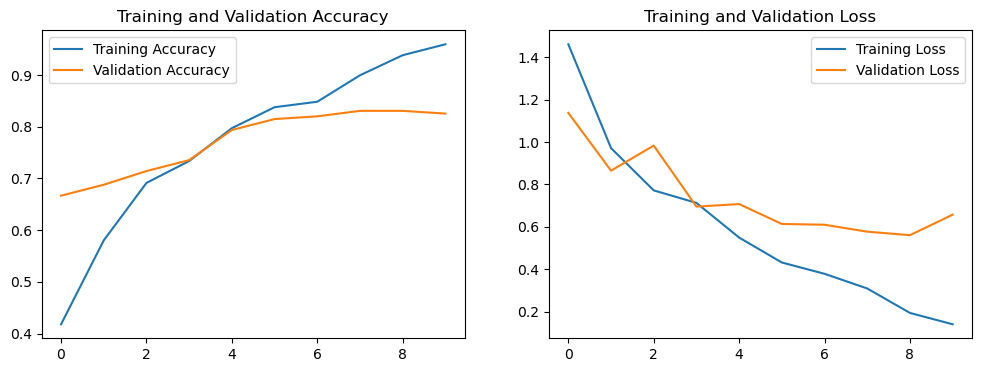

6/6 [==============================] - 0s 38ms/step - loss: 0.4552 - accuracy: 0.8360
Test Accuracy: 83.60%


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32), 
                     (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(MaxPooling2D(2, 2))

    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32), 
                         (3, 3), activation='relu'))
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='malaria_classification'
)

# Perform hyperparameter search
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best model hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Trial 30 Complete [00h 01m 40s]
val_accuracy: 0.8624338507652283

Best val_accuracy So Far: 0.8624338507652283
Total elapsed time: 00h 34m 23s
Best model hyperparameters:
input_units: 96
n_layers: 3
conv_0_units: 96
dense_units: 384
dropout: 0.30000000000000004
conv_1_units: 192
conv_2_units: 224
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
6/6 [==============================] - 1s 129ms/step - loss: 0.6296 - accuracy: 0.7725
Test Accuracy: 77.25%


Epoch 1/10
18/18 [==============================] - 11s 546ms/step - loss: 1.4342 - accuracy: 0.4021 - val_loss: 1.1058 - val_accuracy: 0.5291
Epoch 2/10
18/18 [==============================] - 10s 537ms/step - loss: 1.0051 - accuracy: 0.5573 - val_loss: 0.8728 - val_accuracy: 0.6138
Epoch 3/10
18/18 [==============================] - 9s 513ms/step - loss: 0.8122 - accuracy: 0.6384 - val_loss: 1.1539 - val_accuracy: 0.5661
Epoch 4/10
18/18 [==============================] - 10s 534ms/step - loss: 0.8729 - accuracy: 0.6420 - val_loss: 0.8259 - val_accuracy: 0.7407
Epoch 5/10
18/18 [==============================] - 11s 639ms/step - loss: 0.6856 - accuracy: 0.7354 - val_loss: 0.6792 - val_accuracy: 0.7937
Epoch 6/10
18/18 [==============================] - 10s 553ms/step - loss: 0.6551 - accuracy: 0.7160 - val_loss: 0.6665 - val_accuracy: 0.8148
Epoch 7/10
18/18 [==============================] - 10s 549ms/step - loss: 0.5556 - accuracy: 0.7531 - val_loss: 0.7274 - val_accuracy: 0.8148


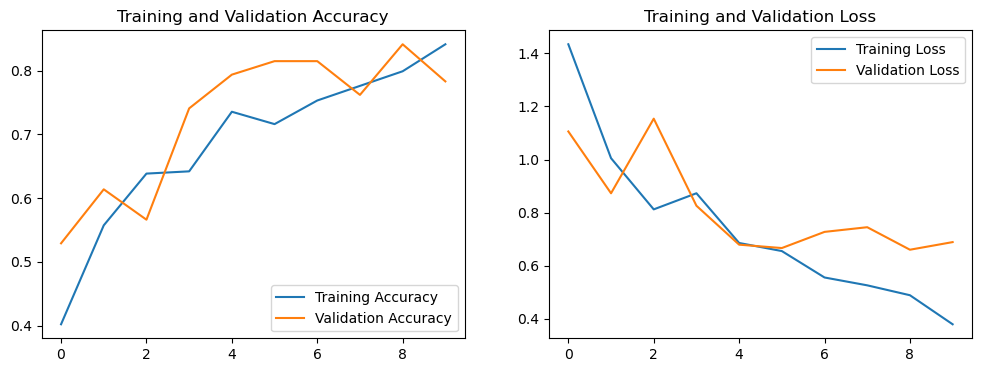

6/6 [==============================] - 1s 111ms/step - loss: 0.6780 - accuracy: 0.7460
Test Accuracy: 74.60%


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Build the CNN model with best hyperparameters
model = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(96, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(192, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(224, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(384, activation='relu'),
    Dropout(0.3),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Function to build the model with hyperparameters including regularization
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32),
                     (3, 3), activation='relu', input_shape=(128, 128, 3),
                     kernel_regularizer=l2(hp.Float('input_l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(MaxPooling2D(2, 2))

    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32),
                         (3, 3), activation='relu',
                         kernel_regularizer=l2(hp.Float(f'conv_{i}_l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    for i in range(hp.Int('n_dense_layers', 1, 3)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32), activation='relu',
                        kernel_regularizer=l2(hp.Float(f'dense_{i}_l2', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='malaria_classification_v2'
)

# Perform hyperparameter search
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best model hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Trial 30 Complete [00h 03m 20s]
val_accuracy: 0.7037037014961243

Best val_accuracy So Far: 0.8359788656234741
Total elapsed time: 00h 25m 07s
Best model hyperparameters:
input_units: 32
input_l2: 4.8450764961487585e-05
n_layers: 2
conv_0_units: 256
conv_0_l2: 0.0011083922643732001
n_dense_layers: 2
dense_0_units: 256
dense_0_l2: 3.8230970085041097e-05
dropout: 0.2
conv_1_units: 224
conv_1_l2: 0.00027087444014448477
dense_1_units: 256
dense_1_l2: 0.0021025670482126687
conv_2_units: 128
conv_2_l2: 3.4586632210195325e-05
conv_3_units: 160
conv_3_l2: 0.00014823574368727963
dense_2_units: 480
dense_2_l2: 0.00014584285646948762
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
6/6 [==============================] - 1s 122ms/step - loss: 0.8667 - accuracy: 0.7619
Test Accuracy: 76.19%


Epoch 1/10
18/18 [==============================] - 12s 632ms/step - loss: 2.0521 - accuracy: 0.4180 - val_loss: 1.9026 - val_accuracy: 0.5714
Epoch 2/10
18/18 [==============================] - 13s 748ms/step - loss: 1.4088 - accuracy: 0.6049 - val_loss: 1.2813 - val_accuracy: 0.6349
Epoch 3/10
18/18 [==============================] - 11s 629ms/step - loss: 1.1676 - accuracy: 0.6578 - val_loss: 1.1139 - val_accuracy: 0.7037
Epoch 4/10
18/18 [==============================] - 12s 675ms/step - loss: 1.0633 - accuracy: 0.7037 - val_loss: 1.2574 - val_accuracy: 0.6296
Epoch 5/10
18/18 [==============================] - 11s 632ms/step - loss: 1.0556 - accuracy: 0.7037 - val_loss: 1.3190 - val_accuracy: 0.6455
Epoch 6/10
18/18 [==============================] - 10s 584ms/step - loss: 0.9602 - accuracy: 0.7337 - val_loss: 1.2085 - val_accuracy: 0.6825
Epoch 7/10
18/18 [==============================] - 11s 611ms/step - loss: 0.9368 - accuracy: 0.7072 - val_loss: 0.9206 - val_accuracy: 0.7989

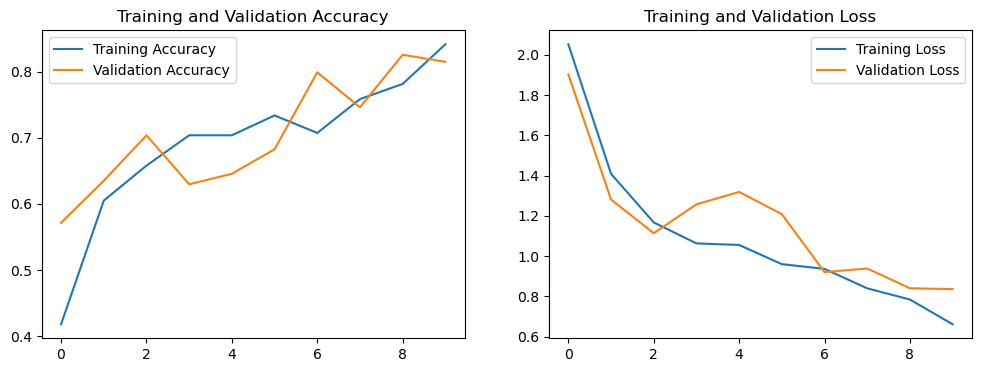

6/6 [==============================] - 1s 125ms/step - loss: 0.8186 - accuracy: 0.8148
Test Accuracy: 81.48%


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Build the CNN model with best hyperparameters
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(4.8450764961487585e-05)),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=l2(0.0011083922643732001)),
    MaxPooling2D(2, 2),
    Conv2D(224, (3, 3), activation='relu', kernel_regularizer=l2(0.00027087444014448477)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(3.8230970085041097e-05)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0021025670482126687)),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Function to build the model with hyperparameters including L1 regularization
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32),
                     (3, 3), activation='relu', input_shape=(128, 128, 3),
                     kernel_regularizer=l1(hp.Float('input_l1', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
    model.add(MaxPooling2D(2, 2))

    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32),
                         (3, 3), activation='relu',
                         kernel_regularizer=l1(hp.Float(f'conv_{i}_l1', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())
    for i in range(hp.Int('n_dense_layers', 1, 3)):
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32), activation='relu',
                        kernel_regularizer=l1(hp.Float(f'dense_{i}_l1', min_value=1e-5, max_value=1e-2, sampling='LOG'))))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(len(classes), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='malaria_classification_v3'
)

# Perform hyperparameter search
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best model hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Trial 30 Complete [00h 02m 10s]
val_accuracy: 0.7354497313499451

Best val_accuracy So Far: 0.8253968358039856
Total elapsed time: 00h 28m 41s
Best model hyperparameters:
input_units: 128
input_l1: 1.26865342072086e-05
n_layers: 3
conv_0_units: 256
conv_0_l1: 2.1199967698668425e-05
n_dense_layers: 3
dense_0_units: 96
dense_0_l1: 1.2607436797378123e-05
dropout: 0.0
dense_1_units: 288
dense_1_l1: 1.6192848039204984e-05
dense_2_units: 128
dense_2_l1: 1.7345718099546966e-05
conv_1_units: 160
conv_1_l1: 0.00019509944080995105
conv_2_units: 128
conv_2_l1: 0.005026221688014422
conv_3_units: 64
conv_3_l1: 0.0004484778177282353
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
6/6 [==============================] - 2s 264ms/step - loss: 1.2041 - accuracy: 0.7460
Test Accuracy: 74.60%


Trial 30 Complete [00h 02m 39s]
val_accuracy: 0.7566137313842773

Best val_accuracy So Far: 0.841269850730896
Total elapsed time: 00h 37m 06s
Best model hyperparameters:
input_units: 64
input_l2: 0.001
n_layers: 1
conv_0_units: 96
conv_0_l2: 0.001
n_dense_layers: 1
dense_0_units: 320
dense_0_l2: 0.001
dropout: 0.1
optimizer: adam
dense_1_units: 224
dense_1_l2: 0.0001
dense_2_units: 512
dense_2_l2: 0.001
dense_3_units: 384
dense_3_l2: 0.01
conv_1_units: 192
conv_1_l2: 0.001
conv_2_units: 192
conv_2_l2: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
6/6 [==============================] - 1s 64ms/step - loss: 0.7070 - accuracy: 0.8571
Test Accuracy: 85.71%


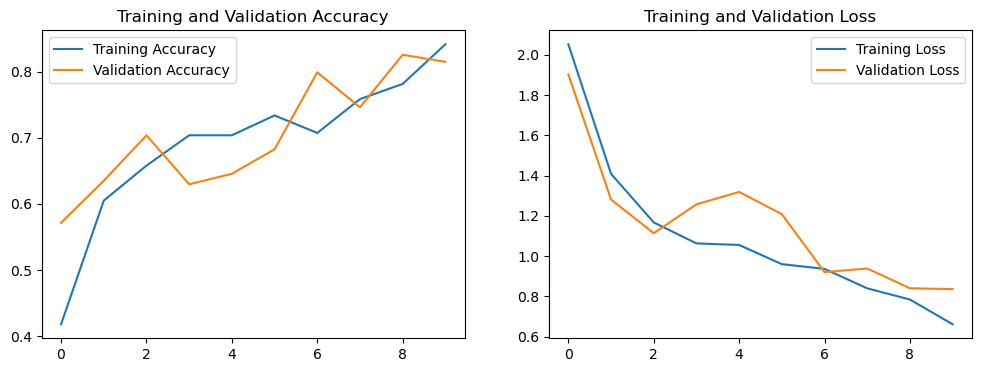

In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from kerastuner.tuners import Hyperband
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Function to build the model with hyperparameters
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=256, step=32),
                     (3, 3), activation='relu', input_shape=(128, 128, 3),
                     kernel_regularizer=l2(hp.Choice('input_l2', values=[1e-4, 1e-3, 1e-2]))))
    model.add(MaxPooling2D(2, 2))

    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=256, step=32),
                         (3, 3), activation='relu',
                         kernel_regularizer=l2(hp.Choice(f'conv_{i}_l2', values=[1e-4, 1e-3, 1e-2]))))
        model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    for i in range(hp.Int('n_dense_layers', 1, 4)):  # Adjust the range as needed
        model.add(Dense(hp.Int(f'dense_{i}_units', min_value=32, max_value=512, step=32), activation='relu',
                        kernel_regularizer=l2(hp.Choice(f'dense_{i}_l2', values=[1e-4, 1e-3, 1e-2]))))
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(len(classes), activation='softmax'))

    # Optimizer choice
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='my_dir',
    project_name='malaria_classification_v4'
)

# Perform hyperparameter search
tuner.search(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model's hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best model hyperparameters:")
for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Epoch 1/10
18/18 [==============================] - 9s 435ms/step - loss: 5.8749 - accuracy: 0.3474 - val_loss: 4.6814 - val_accuracy: 0.4974
Epoch 2/10
18/18 [==============================] - 7s 410ms/step - loss: 4.1628 - accuracy: 0.4727 - val_loss: 3.4677 - val_accuracy: 0.5344
Epoch 3/10
18/18 [==============================] - 7s 393ms/step - loss: 2.9851 - accuracy: 0.6314 - val_loss: 2.8059 - val_accuracy: 0.5873
Epoch 4/10
18/18 [==============================] - 7s 401ms/step - loss: 2.4667 - accuracy: 0.6561 - val_loss: 2.3372 - val_accuracy: 0.6508
Epoch 5/10
18/18 [==============================] - 7s 417ms/step - loss: 2.1516 - accuracy: 0.6896 - val_loss: 1.9540 - val_accuracy: 0.7672
Epoch 6/10
18/18 [==============================] - 7s 410ms/step - loss: 1.8432 - accuracy: 0.7407 - val_loss: 1.9934 - val_accuracy: 0.6455
Epoch 7/10
18/18 [==============================] - 7s 413ms/step - loss: 1.6658 - accuracy: 0.7443 - val_loss: 1.8670 - val_accuracy: 0.6720
Epoch 

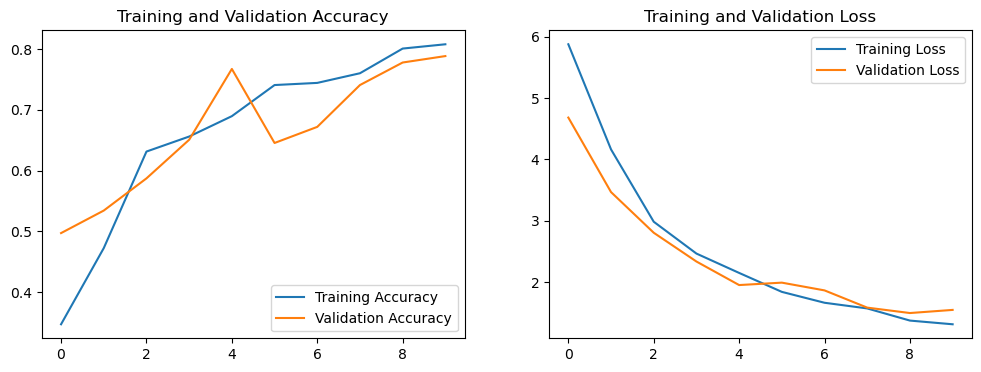

6/6 [==============================] - 0s 62ms/step - loss: 1.5269 - accuracy: 0.7725
Test Accuracy: 77.25%


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Build the CNN model with best hyperparameters
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Conv2D(96, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(320, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(224, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(384, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(val_images, val_labels))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/20
18/18 [==============================] - 9s 417ms/step - loss: 5.9097 - accuracy: 0.3545 - val_loss: 4.8800 - val_accuracy: 0.4815
Epoch 2/20
18/18 [==============================] - 7s 384ms/step - loss: 3.9120 - accuracy: 0.6332 - val_loss: 3.9039 - val_accuracy: 0.6190
Epoch 3/20
18/18 [==============================] - 7s 393ms/step - loss: 3.1326 - accuracy: 0.6402 - val_loss: 2.8816 - val_accuracy: 0.5926
Epoch 4/20
18/18 [==============================] - 7s 417ms/step - loss: 2.4831 - accuracy: 0.6931 - val_loss: 2.3854 - val_accuracy: 0.7249
Epoch 5/20
18/18 [==============================] - 8s 421ms/step - loss: 2.1517 - accuracy: 0.7055 - val_loss: 2.0365 - val_accuracy: 0.7513
Epoch 6/20
18/18 [==============================] - 8s 441ms/step - loss: 1.9017 - accuracy: 0.7637 - val_loss: 1.8272 - val_accuracy: 0.7937
Epoch 7/20
18/18 [==============================] - 7s 405ms/step - loss: 1.7716 - accuracy: 0.7390 - val_loss: 1.8683 - val_accuracy: 0.6772
Epoch 

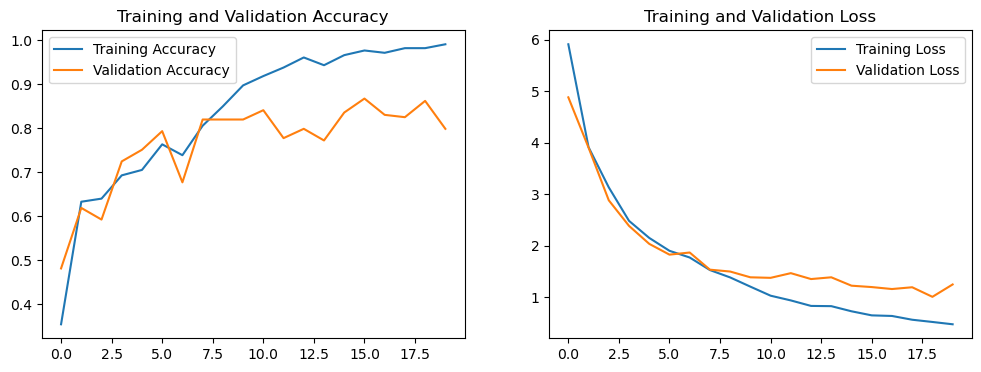

6/6 [==============================] - 0s 62ms/step - loss: 1.0810 - accuracy: 0.8042
Test Accuracy: 80.42%


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Directory paths
base_dir = 'C:\\Users\\Adven\\Documents\\Jupyter_Notebook_Spring2024\\Project_1\\Final_Malaria_Data\\'
classes = os.listdir(base_dir)

# Load and partition dataset
def load_data():
    images = []
    labels = []
    for label, class_name in enumerate(classes):
        class_dir = os.path.join(base_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128, 128))
            image = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image)
            labels.append(label)
    return train_test_split(np.array(images), np.array(labels), test_size=0.4, random_state=42)

train_images, test_images, train_labels, test_labels = load_data()
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

# Normalize the images
train_images = train_images / 255.0
val_images = val_images / 255.0
test_images = test_images / 255.0

# Build the CNN model with best hyperparameters
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Conv2D(96, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(320, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.1),
    Dense(224, activation='relu', kernel_regularizer=l2(0.0001)),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(384, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(len(classes), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels))

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
